## Data Preprocessing

In [1]:
# Import essential libraries and modules
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


# Set the path to your dataset directory
train_data_dir = "../input/labeled-chest-xray-images/chest_xray/train"
test_data_dir = "../input/labeled-chest-xray-images/chest_xray/test"

# Set the hyperparameters
img_width = 224
img_height = 224
batch_size = 16
seed = 123


# Define the data generators with preprocessing steps
train_data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.15 )
test_data_generator = ImageDataGenerator(rescale = 1./255)

# Load the training and validation datasets using the data generator
train_generator = train_data_generator.flow_from_directory(
                  train_data_dir,
                  target_size = (img_width, img_height),
                  batch_size = batch_size,
                  shuffle = True,
                  seed = seed,
                  color_mode = 'rgb',
                  class_mode = 'binary',
                  subset = 'training')
    
validation_generator = train_data_generator.flow_from_directory(
                       train_data_dir,
                       target_size = (img_width, img_height),
                       batch_size = batch_size,
                       shuffle = True,
                       seed = seed,
                       color_mode = 'rgb',
                       class_mode = 'binary',
                       subset ='validation')

# Load the test dataset using the data generator
test_generator = test_data_generator.flow_from_directory(
                 test_data_dir,
                 target_size = (img_width, img_height),
                 batch_size = batch_size,
                 shuffle = False,
                 color_mode = 'rgb',
                 class_mode = 'binary')

Found 4448 images belonging to 2 classes.
Found 784 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [2]:
# Get the number of images for each class in the training set
num_class_0_train = len(train_generator.labels) - sum(train_generator.labels)
num_class_1_train = sum(train_generator.labels)
print("Number of images for class 0 in the training set: ", num_class_0_train)
print("Number of images for class 1 in the training set: ", num_class_1_train)

# Get the number of images for each class in the validation set
num_class_0_val = len(validation_generator.labels) - sum(validation_generator.labels)
num_class_1_val = sum(validation_generator.labels)
print("Number of images for class 0 in the validation set: ", num_class_0_val)
print("Number of images for class 1 in the validation set: ", num_class_1_val)

# Get the number of images for each class in the test set
num_class_0_test = len(test_generator.labels) - sum(test_generator.labels)
num_class_1_test = sum(test_generator.labels)
print("Number of images for class 0 in the test set: ", num_class_0_test)
print("Number of images for class 1 in the test set: ", num_class_1_test)

Number of images for class 0 in the training set:  1147
Number of images for class 1 in the training set:  3301
Number of images for class 0 in the validation set:  202
Number of images for class 1 in the validation set:  582
Number of images for class 0 in the test set:  234
Number of images for class 1 in the test set:  390


## Imbalanced dataset

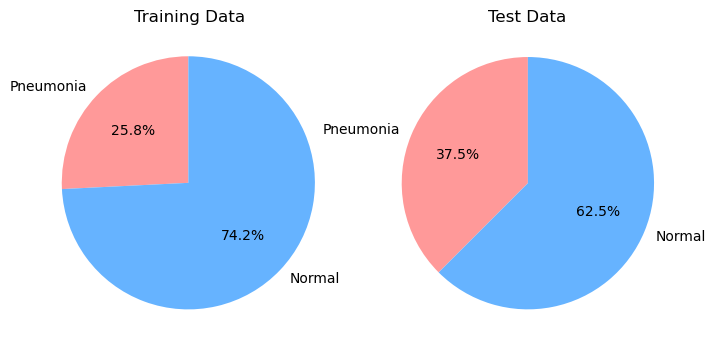

In [6]:
import matplotlib.pyplot as plt

# Define the labels and sizes for the pie charts
labels_train = ['Pneumonia', 'Normal']
sizes_train = [num_class_0_train, num_class_1_train]

labels_test = ['Pneumonia', 'Normal']
sizes_test = [num_class_0_test, num_class_1_test]

# Define the colors for the pie charts
colors = ['#ff9999','#66b3ff']

# Create the subplots for the pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Create the pie chart for the training data
ax1.pie(sizes_train, labels=labels_train, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
ax1.set_title('Training Data')

# Create the pie chart for the test data
ax2.pie(sizes_test, labels=labels_test, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
ax2.set_title('Test Data')

# Display the pie charts
plt.show()

## Image Preprocessing

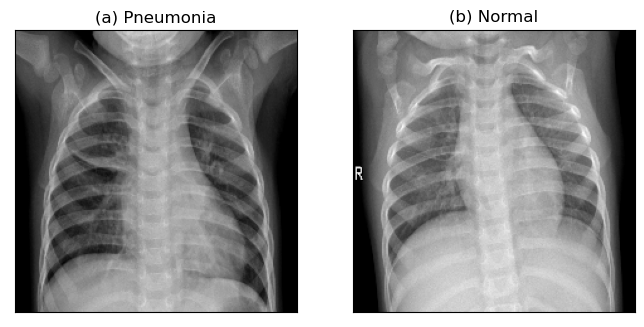

In [7]:
#!pip install opencv-python-headless
import os
import random
import matplotlib.pyplot as plt
import cv2



# Set the path to the train dataset for pneumonia and normal patients
train_path_normal = "../input/labeled-chest-xray-images/chest_xray/train/NORMAL"
train_path_pneumonia = "../input/labeled-chest-xray-images/chest_xray/test/PNEUMONIA"

# Get a list of all the image filenames in the train dataset directory
image_filenames_pneumonia = os.listdir(train_path_pneumonia)
image_filenames_normal = os.listdir(train_path_normal)

# Load the two selected images from pneumania and normal images, respectively
img1 = cv2.imread(os.path.join(train_path_pneumonia, image_filenames_pneumonia[0]), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(train_path_normal, image_filenames_normal[0]), cv2.IMREAD_GRAYSCALE)

# Convert the image to RGB
rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

# Resize the images to the same size
rgb_img1 = cv2.resize(rgb_img1, (224, 224))
rgb_img2 = cv2.resize(rgb_img2, (224, 224))

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Display the first image on the first subplot
ax[0].imshow(rgb_img1)
ax[0].set_title("(a) Pneumonia")
ax[0].set_xticks([])
ax[0].set_yticks([])

# Display the second image on the second subplot
ax[1].imshow(rgb_img2)
ax[1].set_title("(b) Normal")
ax[1].set_xticks([])
ax[1].set_yticks([])

# Show the figure
plt.show()


## Build a model: Transfer Learning
## Pre-trained ResNet50 model on ImageNet 

In [2]:
from keras.applications.resnet import ResNet50
from keras.layers import Input, Dense, Flatten
from keras.models import Model


#Pretrained ResNet50 model on the ImageNet database
base_model = ResNet50(weights = 'imagenet',
                      input_shape = (img_width, img_height, 3),
                      include_top = False)

#Freeze the layers of ResNet50 model
for layer in base_model.layers:
    layer.trainable = False

def resnet_50_imagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model

94765736/94765736 [==============================] - 1s 0us/step


In [3]:
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.optimizers import Adam

resnet_50_imagenet = resnet_50_imagenet()
optimizer = Adam(learning_rate = 0.001)

resnet_50_imagenet.compile(optimizer = optimizer,
                           loss = 'binary_crossentropy',
                           metrics = ['accuracy'])

checkpoint = ModelCheckpoint(filepath = 'resnet_50_imagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)

history_resnet_50_imagenet = resnet_50_imagenet.fit(train_generator,
                                 validation_data = validation_generator,
                                 steps_per_epoch = len(train_generator),
                                 validation_steps = len(validation_generator),
                                 callbacks = [checkpoint],
                                 epochs = 30)

Epoch 1/30
278/278 [==============================] - 120s 381ms/step - loss: 0.4882 - accuracy: 0.8087 - val_loss: 0.2107 - val_accuracy: 0.9133
Epoch 2/30
278/278 [==============================] - 77s 276ms/step - loss: 0.2905 - accuracy: 0.8804 - val_loss: 0.1711 - val_accuracy: 0.9324
Epoch 3/30
278/278 [==============================] - 76s 275ms/step - loss: 0.1977 - accuracy: 0.9213 - val_loss: 0.1188 - val_accuracy: 0.9656
Epoch 4/30
278/278 [==============================] - 77s 278ms/step - loss: 0.1944 - accuracy: 0.9254 - val_loss: 0.1162 - val_accuracy: 0.9656
Epoch 5/30
278/278 [==============================] - 76s 274ms/step - loss: 0.1508 - accuracy: 0.9409 - val_loss: 0.3536 - val_accuracy: 0.8367
Epoch 6/30
278/278 [==============================] - 77s 277ms/step - loss: 0.1863 - accuracy: 0.9269 - val_loss: 0.1003 - val_accuracy: 0.9643
Epoch 7/30
278/278 [==============================] - 76s 274ms/step - loss: 0.1414 - accuracy: 0.9418 - val_loss: 0.1044 - val_a

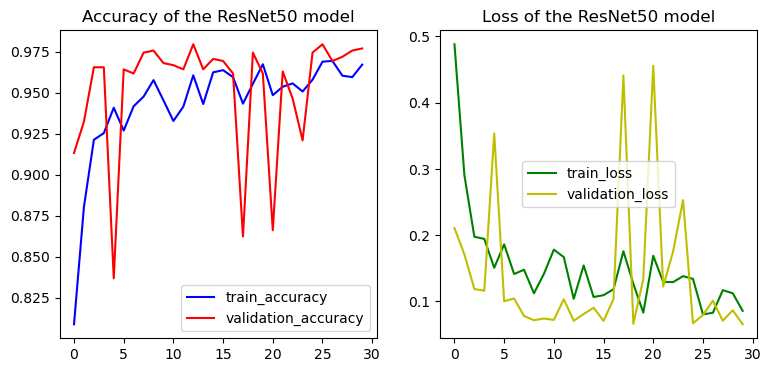

In [6]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_resnet_50_imagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_resnet_50_imagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_resnet_50_imagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_resnet_50_imagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()

# Show the plot
plt.show()

In [7]:
# Load the model
model = tf.keras.models.load_model('resnet_50_imagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 14s 320ms/step - loss: 0.4583 - accuracy: 0.8301
Test loss: 0.46
Test accuracy: 0.83


## Confusion Matrix, Classification Report, AUC-ROC Curve

In [8]:
import numpy as np

# Generate predictions for the test dataset
y_pred = model.predict(test_generator)

# Since the model outputs a probability for each class, we can convert it
# into binary variables as follows:
y_pred = y_pred.round() # or y_pred = np.where(y_pred > 0.5, 1, 0)

# Get the true classes
y_true = test_generator.classes



39/39 [==============================] - 10s 236ms/step


#### Confusion Matrix

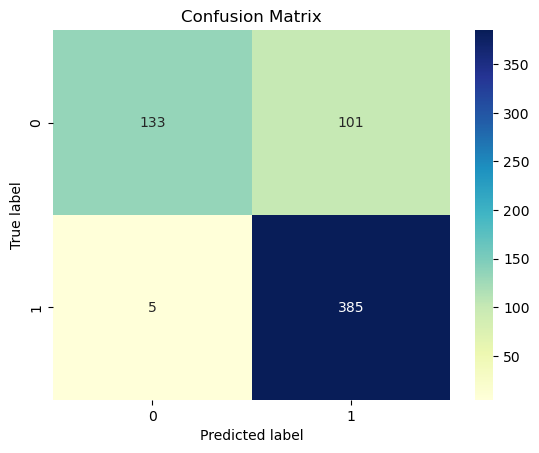

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'g', cmap = "YlGnBu")

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Classification Report

In [10]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred, target_names = class_names)

# Print the classification report
print(class_report)

              precision    recall  f1-score   support

      NORMAL       0.96      0.57      0.72       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



## AUC-ROC curve

39/39 [==============================] - 9s 221ms/step


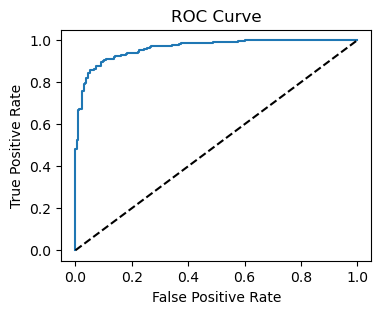

In [11]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
ax.plot(FPR, TPR)
ax.plot([0, 1], [0, 1], '--', color='black') # diagonal line
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()


## Build a model: Transfer Learning
## Pre-trained ResNet50 model on RadImageNet

In [5]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.optimizers import Adam

#Pretrained ResNet50 model on the RadImageNet database

from tensorflow.keras.models import load_model

model_dir = '../input/radimagenet/RadImageNet/RadImageNet-ResNet50_notop.h5'
resnet_50 = load_model(model_dir)

#Freeze the layers of ResNet50 model
for layer in resnet_50.layers:
    layer.trainable = False

def resnet_50_radimagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = resnet_50(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model


resnet_50_radimagenet = resnet_50_radimagenet()

optimizer = Adam(learning_rate = 0.001)

resnet_50_radimagenet.compile(optimizer = optimizer,
                              loss = 'binary_crossentropy',
                              metrics = 'accuracy')

checkpoint = ModelCheckpoint(filepath = 'resnet_50_radimagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)

history_resnet_50_radimagenet = resnet_50_radimagenet.fit(train_generator,
                                validation_data = validation_generator,
                                steps_per_epoch = len(train_generator),
                                validation_steps = len(validation_generator),
                                callbacks = [checkpoint],
                                epochs = 30)

Epoch 1/30
278/278 [==============================] - 126s 413ms/step - loss: 0.1408 - accuracy: 0.9519 - val_loss: 0.0640 - val_accuracy: 0.9809
Epoch 2/30
278/278 [==============================] - 74s 266ms/step - loss: 0.0586 - accuracy: 0.9795 - val_loss: 0.0705 - val_accuracy: 0.9809
Epoch 3/30
278/278 [==============================] - 74s 267ms/step - loss: 0.0365 - accuracy: 0.9847 - val_loss: 0.0942 - val_accuracy: 0.9681
Epoch 4/30
278/278 [==============================] - 76s 272ms/step - loss: 0.0147 - accuracy: 0.9944 - val_loss: 0.0800 - val_accuracy: 0.9758
Epoch 5/30
278/278 [==============================] - 75s 269ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.0696 - val_accuracy: 0.9834
Epoch 6/30
278/278 [==============================] - 76s 272ms/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.0528 - val_accuracy: 0.9860
Epoch 7/30
278/278 [==============================] - 75s 271ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0579 - val_a

In [6]:
# Load the model
model = tf.keras.models.load_model('resnet_50_radimagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f"Validation loss: {round(loss, 2)}")
print(f"Validation accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 16s 366ms/step - loss: 0.6749 - accuracy: 0.8750
Validation loss: 0.67
Validation accuracy: 0.88


In [ ]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_resnet_50_radimagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_resnet_50_radimagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_resnet_50_radimagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_resnet_50_radimagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()

# Show the plot
plt.show()

#### Comparison: ResNet50: ImageNet vs RadImageNet

#### On the training dataset:

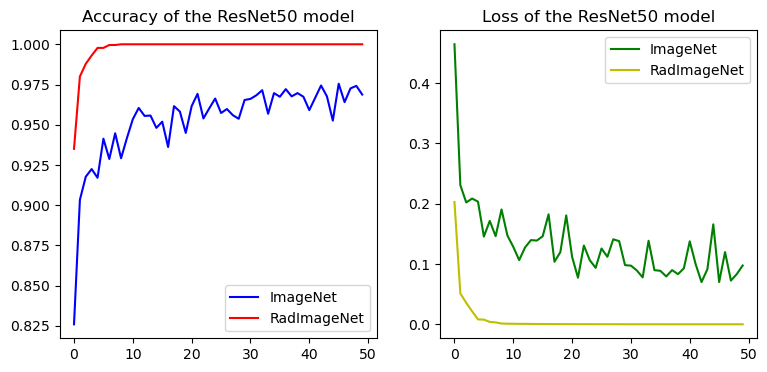

In [55]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_resnet_50_imagenet.history['accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_resnet_50_radimagenet.history['accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_resnet_50_imagenet.history['loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_resnet_50_radimagenet.history['loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()

# Show the plot
plt.show()

#### On the validation dataset:

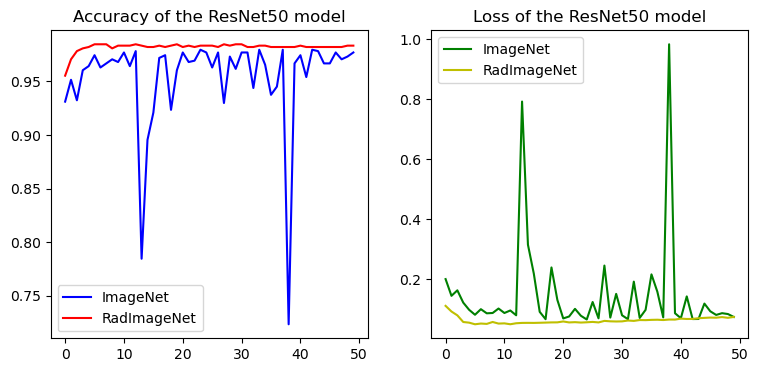

In [56]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_resnet_50_imagenet.history['val_accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_resnet_50_radimagenet.history['val_accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the ResNet50 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_resnet_50_imagenet.history['val_loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_resnet_50_radimagenet.history['val_loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the ResNet50 model')
ax[1].legend()

# Show the plot
plt.show()

## On Metrics: Confusion Matrix, Classification Report, AUC-ROC Curve 

In [8]:
# Generate predictions for the validation dataset
y_pred = model.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 10s 222ms/step


#### Confusion Matrix

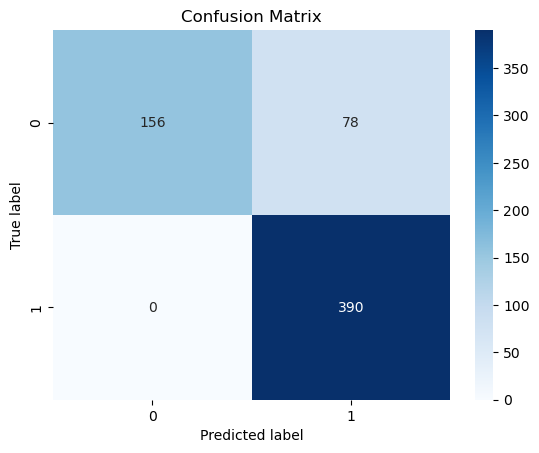

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = 'Blues')#"YlGnBu")

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


#### Classification Report

In [10]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred,target_names = class_names)

# Print the classification report
print(class_report)


              precision    recall  f1-score   support

      NORMAL       1.00      0.67      0.80       234
   PNEUMONIA       0.83      1.00      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.83      0.85       624
weighted avg       0.90      0.88      0.87       624



#### AUC-ROC curve

39/39 [==============================] - 9s 224ms/step


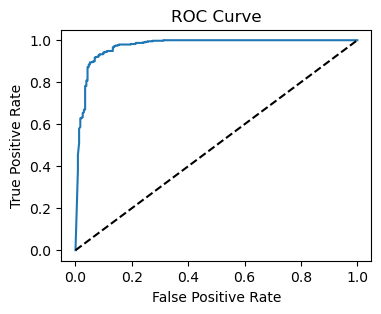

In [11]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black') # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


## Build a model: Transfer Learning
## Pre-trained DenseNet121 model on ImageNet

In [63]:
from keras.applications.densenet import DenseNet121

#Pretrained DenseNet121 model on the ImageNet database
base_model = DenseNet121(weights = 'imagenet',
                         input_shape = (img_width, img_height, 3),
                         include_top = False)

#Freeze the layers of DenseNet121 model
for layer in base_model.layers:
    layer.trainable = False

def densenet_121_imagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model_121 = Model(inputs = inputs, outputs = outputs)
    return model_121


densenet_121_imagenet = densenet_121_imagenet()

optimizer = Adam(learning_rate = 0.001)

densenet_121_imagenet.compile(optimizer = optimizer,
                              loss = 'binary_crossentropy',
                              metrics = ['accuracy'])

checkpoint = ModelCheckpoint(filepath = 'densenet_121_imagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)

history_densenet_121_imagenet = densenet_121_imagenet.fit(train_generator,
                                validation_data = validation_generator,
                                steps_per_epoch = len(train_generator),
                                validation_steps = len(validation_generator),
                                callbacks = [checkpoint],
                                epochs = 50)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
278/278 [==============================] - 87s 287ms/step - loss: 0.3108 - accuracy: 0.9379 - val_loss: 0.0411 - val_accuracy: 0.9834
Epoch 2/50
278/278 [==============================] - 73s 262ms/step - loss: 0.0885 - accuracy: 0.9773 - val_loss: 0.0479 - val_accuracy: 0.9860
Epoch 3/50
278/278 [==============================] - 73s 262ms/step - loss: 0.0578 - accuracy: 0.9845 - val_loss: 0.0429 - val_accuracy: 0.9898
Epoch 4/50
278/278 [==============================] - 73s 262ms/step - loss: 0.0489 - accuracy: 0.9879 - val_loss: 0.0458 - val_accuracy: 0.9911
Epoch 5/50
278/278 [==============================] - 74s 265ms/step - loss: 0.0822 - accuracy: 0.9852 - val_loss: 0.1582 - val_accuracy: 0.9770
Epoch 6/50
278/278 [==============================] - 73s 263ms/step - loss: 0.0249 - accuracy: 0.9924 - val_loss: 0.1482 - val_accuracy: 0.9770
Epoch 7/50
278/278 [==============================] - 83s 299ms/s

In [65]:
# Load the model
model_121 = tf.keras.models.load_model('densenet_121_imagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model_121.evaluate(test_generator)

print(f"Validation loss: {round(loss, 2)}")
print(f"Validation accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 11s 225ms/step - loss: 1.8297 - accuracy: 0.8926
Validation loss: 1.83
Validation accuracy: 0.89


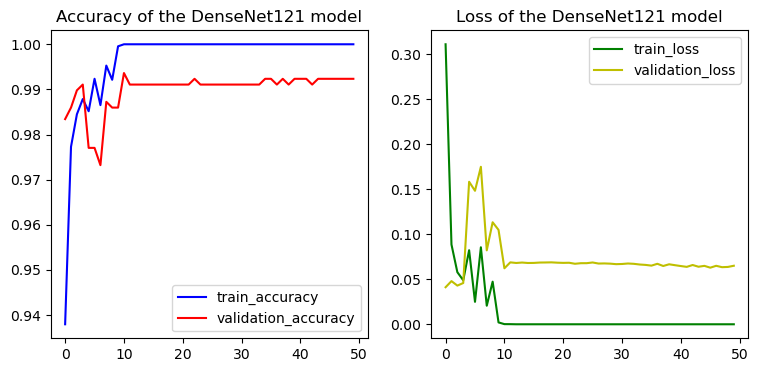

In [66]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_densenet_121_imagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_densenet_121_imagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the DenseNet121 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_densenet_121_imagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_densenet_121_imagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the DenseNet121 model')
ax[1].legend()

# Show the plot
plt.show()

#### On Metrics: Confusion Matrix, Classification Report, AUC-ROC Curve

In [67]:
# Generate predictions for the validation dataset
y_pred = model_121.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 10s 218ms/step


#### Confusion Matrix

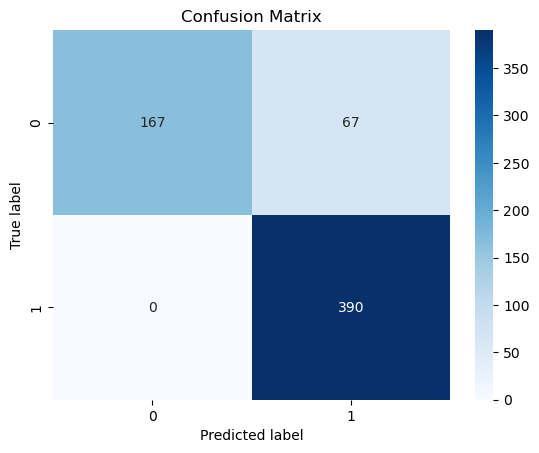

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = 'Blues')#"YlGnBu")

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

#### Classification Report

In [69]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred,target_names = class_names)

# Print the classification report
print(class_report)


              precision    recall  f1-score   support

      NORMAL       1.00      0.71      0.83       234
   PNEUMONIA       0.85      1.00      0.92       390

    accuracy                           0.89       624
   macro avg       0.93      0.86      0.88       624
weighted avg       0.91      0.89      0.89       624



#### AUC-ROC Curve

39/39 [==============================] - 9s 214ms/step


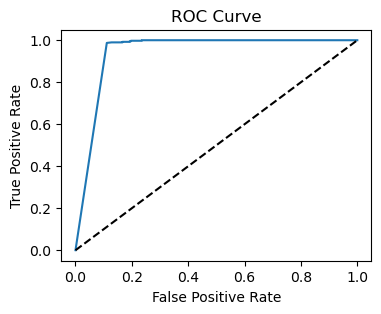

In [78]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model_121.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black') # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


## Build a model: Transfer Learning
## Pre-trained DenseNet121 model on RadImageNet

In [79]:
#Pretrained DenseNet121 model on the RadImageNet database

from tensorflow.keras.models import load_model

model_dir = '../input/radimagenet/RadImageNet/RadImageNet-DenseNet121_notop.h5'
densenet_121 = load_model(model_dir)

#Freeze the layers of DenseNet121 model
for layer in densenet_121.layers:
    layer.trainable = False

def densenet_121_radimagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = densenet_121(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model


densenet_121_radimagenet = densenet_121_radimagenet()

optimizer = Adam(learning_rate = 0.001)

densenet_121_radimagenet.compile(optimizer = optimizer,
                                 loss = 'binary_crossentropy',
                                 metrics = 'accuracy')

checkpoint = ModelCheckpoint(filepath = 'densenet_121_radimagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)
history_densenet_121_radimagenet = densenet_121_radimagenet.fit(train_generator,
                                   validation_data = validation_generator,
                                   steps_per_epoch = len(train_generator),
                                   validation_steps = len(validation_generator),
                                   callbacks = [checkpoint],
                                   epochs = 50)

Epoch 1/50
278/278 [==============================] - 82s 276ms/step - loss: 0.1255 - accuracy: 0.9555 - val_loss: 0.0471 - val_accuracy: 0.9847
Epoch 2/50
278/278 [==============================] - 73s 262ms/step - loss: 0.0554 - accuracy: 0.9804 - val_loss: 0.0741 - val_accuracy: 0.9707
Epoch 3/50
278/278 [==============================] - 73s 264ms/step - loss: 0.0516 - accuracy: 0.9820 - val_loss: 0.0601 - val_accuracy: 0.9783
Epoch 4/50
278/278 [==============================] - 74s 265ms/step - loss: 0.0465 - accuracy: 0.9831 - val_loss: 0.0492 - val_accuracy: 0.9796
Epoch 5/50
278/278 [==============================] - 73s 264ms/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 0.0287 - val_accuracy: 0.9847
Epoch 6/50
278/278 [==============================] - 72s 260ms/step - loss: 0.0128 - accuracy: 0.9951 - val_loss: 0.0553 - val_accuracy: 0.9770
Epoch 7/50
278/278 [==============================] - 73s 261ms/step - loss: 0.0209 - accuracy: 0.9917 - val_loss: 0.0870 - val_ac

In [80]:
# Load the model
model_121_ = tf.keras.models.load_model('densenet_121_radimagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model_121_.evaluate(test_generator)

print(f"Validation loss: {round(loss, 2)}")
print(f"Validation accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 11s 231ms/step - loss: 0.7838 - accuracy: 0.8446
Validation loss: 0.78
Validation accuracy: 0.84


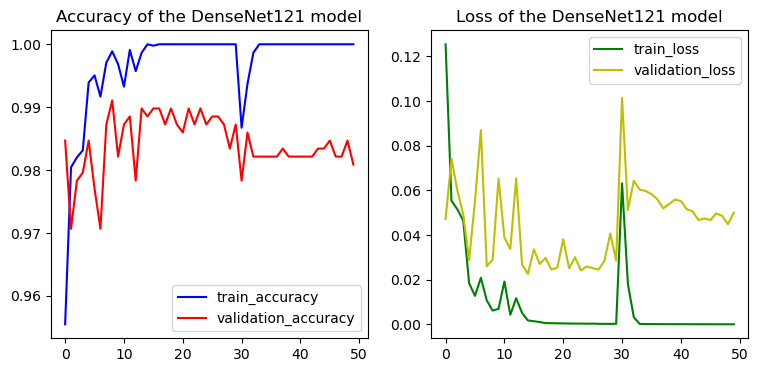

In [81]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_densenet_121_radimagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_densenet_121_radimagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the DenseNet121 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_densenet_121_radimagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_densenet_121_radimagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the DenseNet121 model')
ax[1].legend()

#### On Metrics: Confusion Matrix, Classification Report, AUC-ROC Curve

In [82]:
# Generate predictions for the validation dataset
y_pred = model_121_.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 11s 229ms/step


#### Confusion Matrix

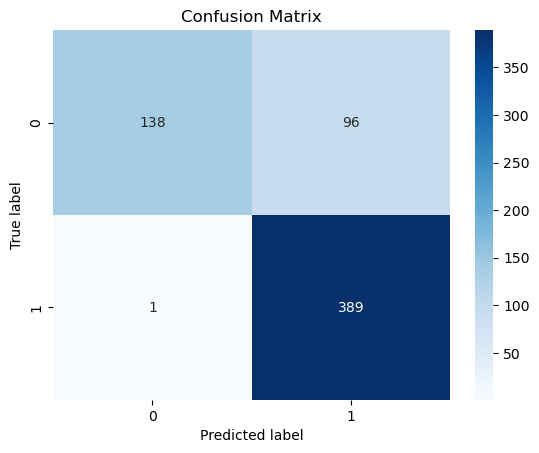

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = 'Blues')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

####  Classification Report

In [87]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred,target_names = class_names)

# Print the classification report
print(class_report)


              precision    recall  f1-score   support

      NORMAL       0.99      0.59      0.74       234
   PNEUMONIA       0.80      1.00      0.89       390

    accuracy                           0.84       624
   macro avg       0.90      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



#### AUC-ROC Curve

39/39 [==============================] - 8s 211ms/step


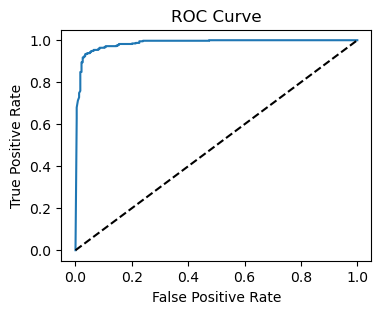

In [88]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model_121_.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black') # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Comparison: DenseNet121: ImageNet vs RadImageNet

#### On the training dataset:

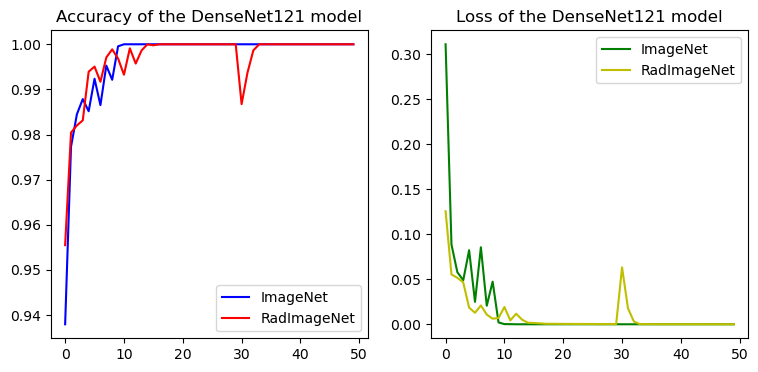

In [90]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_densenet_121_imagenet.history['accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_densenet_121_radimagenet.history['accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the DenseNet121 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_densenet_121_imagenet.history['loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_densenet_121_radimagenet.history['loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the DenseNet121 model')
ax[1].legend()

# Show the plot
plt.show()

#### On the validation dataset:

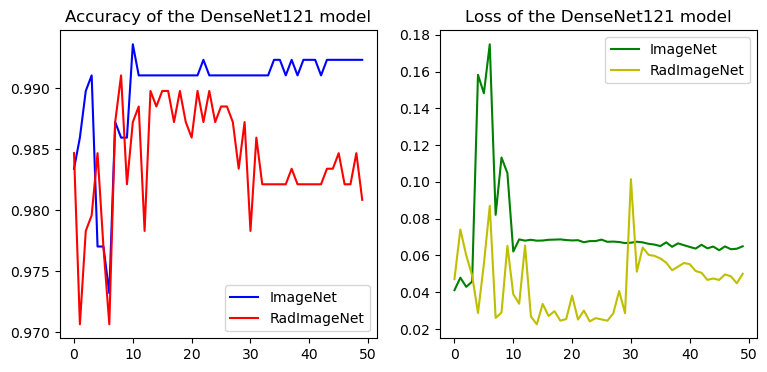

In [91]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_densenet_121_imagenet.history['val_accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_densenet_121_radimagenet.history['val_accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the DenseNet121 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_densenet_121_imagenet.history['val_loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_densenet_121_radimagenet.history['val_loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the DenseNet121 model')
ax[1].legend()

# Show the plot
plt.show()

## Build a model: Transfer Learning
## Pre-trained InceptionV3InceptionResNetV2 model on ImageNet

In [93]:
#Pre-trained InceptionV3 model on the ImageNet database

from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights = 'imagenet',
                         input_shape = (img_width, img_height, 3),
                         include_top = False)

#Freeze the layers of InceptionV3 model
for layer in base_model.layers:
    layer.trainable = False

def inception_v3_imagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model


inception_v3_imagenet = inception_v3_imagenet()

optimizer = Adam(learning_rate = 0.001)

inception_v3_imagenet.compile(optimizer = optimizer,
                              loss = 'binary_crossentropy',
                              metrics = ['accuracy'])

checkpoint = ModelCheckpoint(filepath = 'densenet_121_imagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)

history_inception_v3_imagenet = inception_v3_imagenet.fit(train_generator,
                                validation_data = validation_generator,
                                steps_per_epoch = len(train_generator),
                                validation_steps = len(validation_generator),
                                callbacks = [checkpoint],
                                epochs = 50)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/50
278/278 [==============================] - 79s 269ms/step - loss: 0.4667 - accuracy: 0.9211 - val_loss: 0.2183 - val_accuracy: 0.9681
Epoch 2/50
278/278 [==============================] - 72s 260ms/step - loss: 0.2038 - accuracy: 0.9638 - val_loss: 0.2759 - val_accuracy: 0.9541
Epoch 3/50
278/278 [==============================] - 73s 261ms/step - loss: 0.2091 - accuracy: 0.9667 - val_loss: 0.2796 - val_accuracy: 0.9719
Epoch 4/50
278/278 [==============================] - 72s 259ms/step - loss: 0.1503 - accuracy: 0.9773 - val_loss: 0.3391 - val_accuracy: 0.9592
Epoch 5/50
278/278 [==============================] - 72s 258ms/step - loss: 0.0394 - accuracy: 0.9901 - val_loss: 0.3876 - val_accuracy: 0.9579
Epoch 6/50
278/278 [==============================] - 72s 258ms/step - loss: 0.1033 - accuracy: 0.9852 - val_loss: 0.3206 - val_accuracy: 0.9719
Epoch 7/50
278/278 [==============================] - 82s 296ms/s

In [98]:
# Load the model
model_v3 = tf.keras.models.load_model('inception_v3_imagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model_v3.evaluate(test_generator)

print(f"Validation loss: {round(loss, 2)}")
print(f"Validation accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 10s 231ms/step - loss: 2.7030 - accuracy: 0.8686
Validation loss: 2.7
Validation accuracy: 0.87


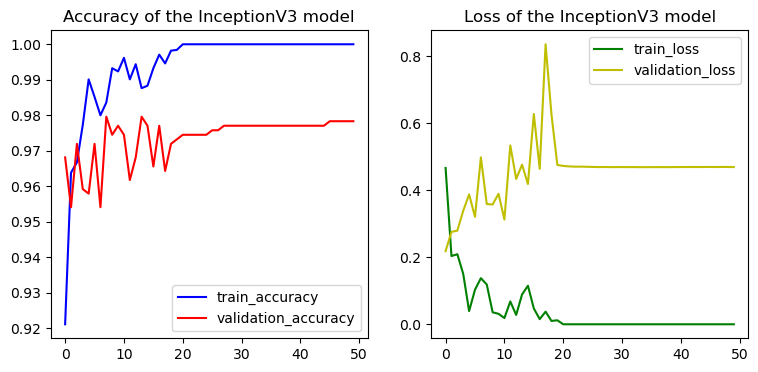

In [99]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_v3_imagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_inception_v3_imagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the InceptionV3 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_v3_imagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_inception_v3_imagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the InceptionV3 model')
ax[1].legend()

# Show the plot
plt.show()

## On Metrics: Confusion Matrix, Classification Report, AUC-ROC Curve

In [100]:
# Generate predictions for the validation dataset
y_pred = model_v3.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 10s 212ms/step


#### Confusion Matrix

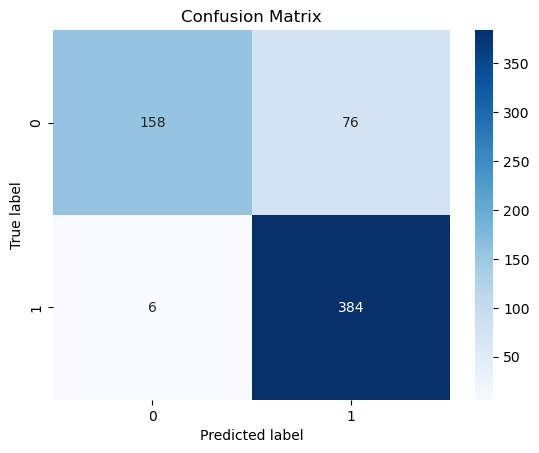

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = 'Blues')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

#### Classification Report

In [102]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred, target_names = class_names)

# Print the classification report
print(class_report)


              precision    recall  f1-score   support

      NORMAL       0.96      0.68      0.79       234
   PNEUMONIA       0.83      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



#### AUC-ROC Curve

39/39 [==============================] - 8s 214ms/step


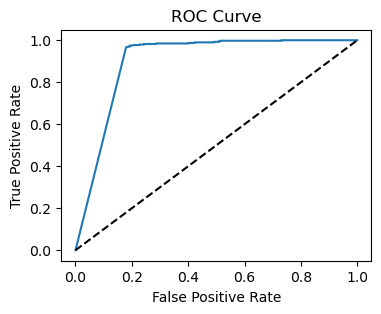

In [103]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model_v3.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black') # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Build a model: Transfer Learning
## Pre-trained InceptionV3 model on RadImageNet

In [105]:
#Pretrained InceptionV3 model on the RadImageNet database

from tensorflow.keras.models import load_model

model_dir = '../input/radimagenet/RadImageNet/RadImageNet-InceptionV3_notop.h5'
inception_v3 = load_model(model_dir)

#Freeze the layers of InceptionV3 model
for layer in inception_v3.layers:
    layer.trainable = False

def inception_v3_radimagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = inception_v3(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model


inception_v3_radimagenet = inception_v3_radimagenet()

optimizer = Adam(learning_rate = 0.001)

inception_v3_radimagenet.compile(optimizer = optimizer,
                                 loss = 'binary_crossentropy',
                                 metrics = 'accuracy')

checkpoint = ModelCheckpoint(filepath = 'inception_v3_radimagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)
history_inception_v3_radimagenet = inception_v3_radimagenet.fit(train_generator,
                                   validation_data = validation_generator,
                                   steps_per_epoch = len(train_generator),
                                   validation_steps = len(validation_generator),
                                   callbacks = [checkpoint],
                                   epochs = 50)

Epoch 1/50
278/278 [==============================] - 80s 273ms/step - loss: 0.2103 - accuracy: 0.9098 - val_loss: 0.1627 - val_accuracy: 0.9209
Epoch 2/50
278/278 [==============================] - 74s 267ms/step - loss: 0.1329 - accuracy: 0.9496 - val_loss: 0.1260 - val_accuracy: 0.9490
Epoch 3/50
278/278 [==============================] - 74s 267ms/step - loss: 0.1096 - accuracy: 0.9595 - val_loss: 0.1162 - val_accuracy: 0.9528
Epoch 4/50
278/278 [==============================] - 73s 264ms/step - loss: 0.0944 - accuracy: 0.9658 - val_loss: 0.1533 - val_accuracy: 0.9439
Epoch 5/50
278/278 [==============================] - 73s 264ms/step - loss: 0.0809 - accuracy: 0.9717 - val_loss: 0.1153 - val_accuracy: 0.9515
Epoch 6/50
278/278 [==============================] - 73s 263ms/step - loss: 0.0779 - accuracy: 0.9732 - val_loss: 0.1078 - val_accuracy: 0.9503
Epoch 7/50
278/278 [==============================] - 73s 264ms/step - loss: 0.0685 - accuracy: 0.9750 - val_loss: 0.1041 - val_ac

In [106]:
# Load the model
model_v3_ = tf.keras.models.load_model('inception_v3_radimagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model_v3.evaluate(test_generator)

print(f"Validation loss: {round(loss, 2)}")
print(f"Validation accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 9s 230ms/step - loss: 2.7030 - accuracy: 0.8686
Validation loss: 2.7
Validation accuracy: 0.87


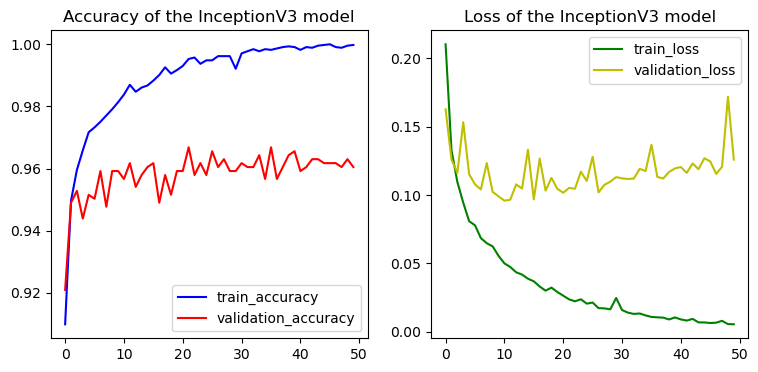

In [107]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_v3_radimagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_inception_v3_radimagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the InceptionV3 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_v3_radimagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_inception_v3_radimagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the InceptionV3 model')
ax[1].legend()

# Show the plot
plt.show()

## Comparison: InceptionV3: ImageNet vs RadImageNet

#### On the training dataset:

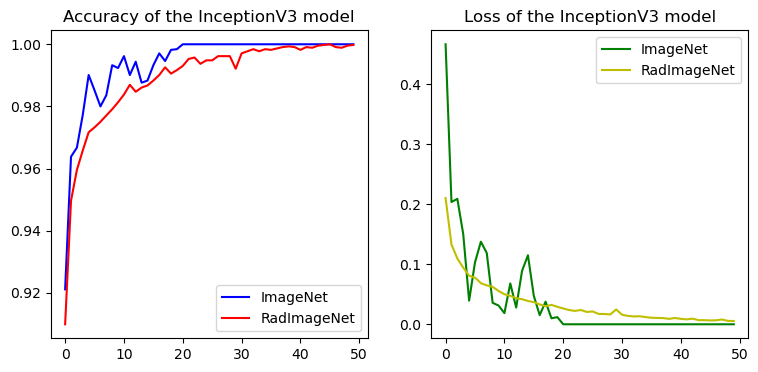

In [108]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_v3_imagenet.history['accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_inception_v3_radimagenet.history['accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the InceptionV3 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_v3_imagenet.history['loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_inception_v3_radimagenet.history['loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the InceptionV3 model')
ax[1].legend()

# Show the plot
plt.show()

#### On the validation dataset:

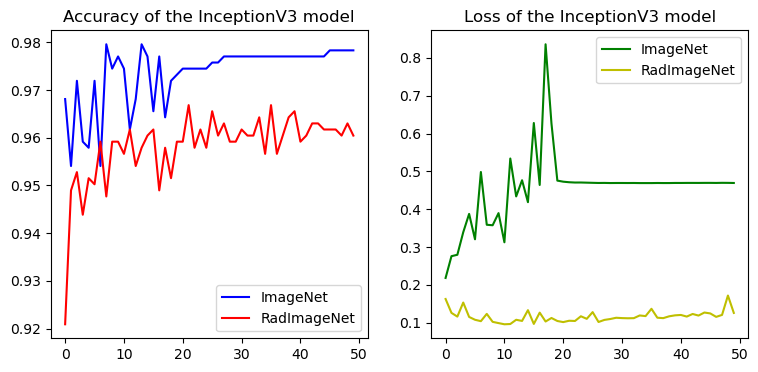

In [109]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_v3_imagenet.history['val_accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_inception_v3_radimagenet.history['val_accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the InceptionV3 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_v3_imagenet.history['val_loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_inception_v3_radimagenet.history['val_loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the InceptionV3 model')
ax[1].legend()

# Show the plot
plt.show()

## On Metrics: Confusion Matrix, Classification Report, AUC-ROC Curve

In [110]:
# Generate predictions for the validation dataset
y_pred = model_v3_.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 10s 212ms/step


#### Confusion Matrix

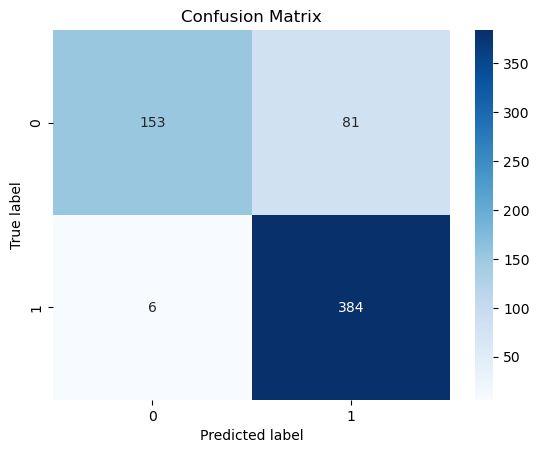

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = 'Blues')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

#### Classification Report

In [114]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred,target_names = class_names)

# Print the classification report
print(class_report)

              precision    recall  f1-score   support

      NORMAL       0.96      0.65      0.78       234
   PNEUMONIA       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



#### AUC-ROC Curve

39/39 [==============================] - 8s 208ms/step


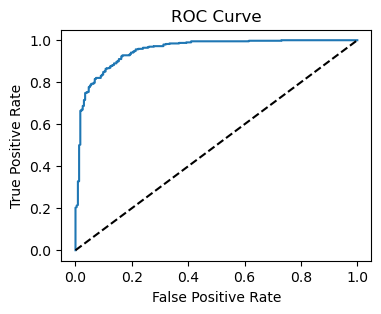

In [116]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model_v3_.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black') # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Build a model: Transfer Learning
## Pre-trained InceptionResNetV2 model on ImageNet


In [6]:
#Pre-trained InceptionResNetV2 model on the ImageNet database

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.optimizers import Adam



base_model = InceptionResNetV2(weights = 'imagenet',
                               input_shape = (img_width, img_height, 3),
                               include_top = False)

#Freeze the layers of InceptionResNetV2 model
for layer in base_model.layers:
    layer.trainable = False

def inception_resnet_v2_imagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model


inception_resnet_v2_imagenet = inception_resnet_v2_imagenet()

optimizer = Adam(learning_rate = 0.001)

inception_resnet_v2_imagenet.compile(optimizer = optimizer,
                              loss = 'binary_crossentropy',
                              metrics = ['accuracy'])

checkpoint = ModelCheckpoint(filepath = 'inception_resnet_v2_imagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)
history_inception_resnet_v2_imagenet = inception_resnet_v2_imagenet.fit(train_generator,
                                       validation_data = validation_generator,
                                       steps_per_epoch = len(train_generator),
                                       validation_steps = len(validation_generator),
                                       callbacks = [checkpoint],
                                       epochs = 50)

Epoch 1/50
278/278 [==============================] - 153s 488ms/step - loss: 0.4527 - accuracy: 0.9283 - val_loss: 0.1306 - val_accuracy: 0.9796
Epoch 2/50
278/278 [==============================] - 78s 281ms/step - loss: 0.1596 - accuracy: 0.9710 - val_loss: 0.2309 - val_accuracy: 0.9630
Epoch 3/50
278/278 [==============================] - 79s 285ms/step - loss: 0.1012 - accuracy: 0.9789 - val_loss: 0.1301 - val_accuracy: 0.9821
Epoch 4/50
278/278 [==============================] - 78s 281ms/step - loss: 0.1933 - accuracy: 0.9719 - val_loss: 0.1960 - val_accuracy: 0.9745
Epoch 5/50
278/278 [==============================] - 80s 289ms/step - loss: 0.1038 - accuracy: 0.9836 - val_loss: 0.2237 - val_accuracy: 0.9847
Epoch 6/50
278/278 [==============================] - 77s 277ms/step - loss: 0.0617 - accuracy: 0.9876 - val_loss: 0.3395 - val_accuracy: 0.9707
Epoch 7/50
278/278 [==============================] - 78s 281ms/step - loss: 0.0651 - accuracy: 0.9894 - val_loss: 0.1757 - val_a

In [7]:
# Load the model
model_v2 = tf.keras.models.load_model('inception_resnet_v2_imagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model_v2.evaluate(test_generator)

print(f"Validation loss: {round(loss, 2)}")
print(f"Validation accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 18s 372ms/step - loss: 4.7020 - accuracy: 0.8734
Validation loss: 4.7
Validation accuracy: 0.87


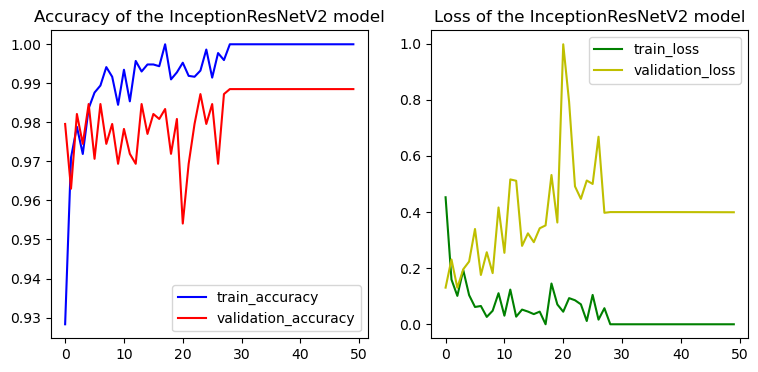

In [8]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_resnet_v2_imagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_inception_resnet_v2_imagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the InceptionResNetV2 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_resnet_v2_imagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_inception_resnet_v2_imagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the InceptionResNetV2 model')
ax[1].legend()

# Show the plot
plt.show()

## Comparison: InceptionResNetV2: Imagenet vs RadImageNet

#### On the training dataset

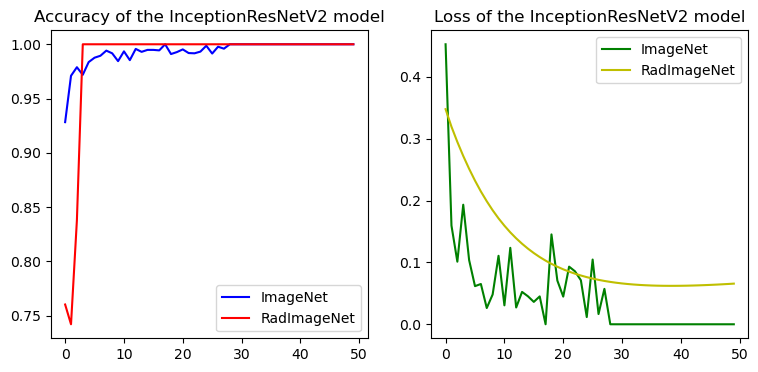

In [30]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_resnet_v2_imagenet.history['accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_inception_resnet_v2_radimagenet.history['accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the InceptionResNetV2 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_resnet_v2_imagenet.history['loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_inception_resnet_v2_radimagenet.history['val_loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the InceptionResNetV2 model')
ax[1].legend()

# Show the plot
plt.show()

#### On the validation dataset

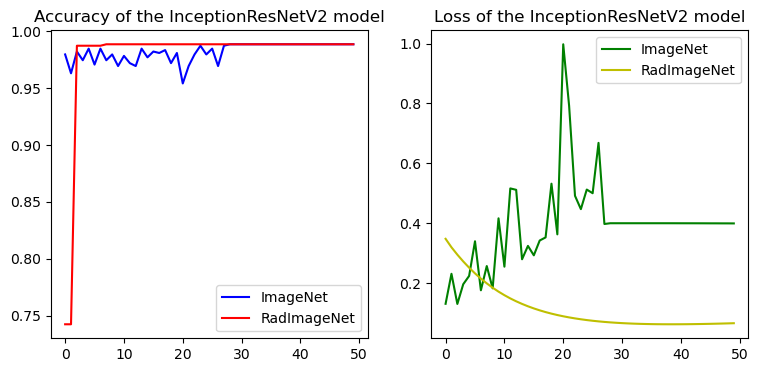

In [31]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_resnet_v2_imagenet.history['val_accuracy'], c = 'b', label = 'ImageNet')
ax[0].plot(history_inception_resnet_v2_radimagenet.history['val_accuracy'], c = 'r', label = 'RadImageNet')
ax[0].set_title('Accuracy of the InceptionResNetV2 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_resnet_v2_imagenet.history['val_loss'], c = 'g', label = 'ImageNet')
ax[1].plot(history_inception_resnet_v2_radimagenet.history['val_loss'], c = 'y', label = 'RadImageNet')
ax[1].set_title('Loss of the InceptionResNetV2 model')
ax[1].legend()

# Show the plot
plt.show()

## On Metrics: Confusion Matrix, Classification Report, ROC-AUC Curve

In [9]:
# Generate predictions for the validation dataset
y_pred = model_v2.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 12s 230ms/step


## Confusion Matrix

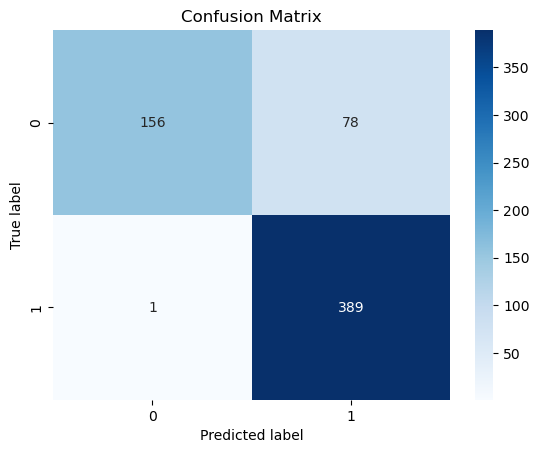

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = 'Blues')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Classification Report

In [11]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred, target_names = class_names)

# Print the classification report
print(class_report)

              precision    recall  f1-score   support

      NORMAL       0.99      0.67      0.80       234
   PNEUMONIA       0.83      1.00      0.91       390

    accuracy                           0.87       624
   macro avg       0.91      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624



## AUC-ROC Curve

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_true, y_pred)

print("AUC-ROC score on test data:", auc_roc)


39/39 [==============================] - 9s 237ms/step


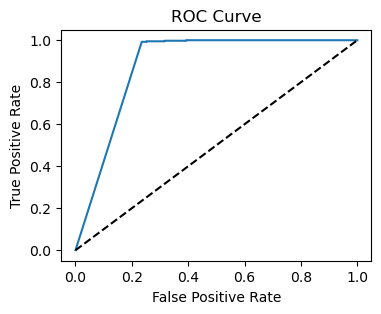

In [12]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model_v2.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black') # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Build a model: Transfer Learning
## Pre-trained InceptionResNetV2 model on RadImageNet

In [22]:
#Pretrained InceptionResNetV2 model on the RadImageNet database

from tensorflow.keras.models import load_model

model_dir = '/kaggle/working/inception_resnet_v2_imagenet.h5'
inception_res_v2 = load_model(model_dir)

#Freeze the layers of InceptionResNetV2 model
for layer in inception_res_v2.layers:
    layer.trainable = False

def inception_resnet_v2_radimagenet():
    inputs = Input(shape = (img_width, img_height, 3))
    x = inception_res_v2(inputs)
    x = Flatten()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model


inception_resnet_v2_radimagenet = inception_resnet_v2_radimagenet()

optimizer = Adam(learning_rate = 0.001)

inception_resnet_v2_radimagenet.compile(optimizer = optimizer,
                                        loss = 'binary_crossentropy',
                                        metrics = 'accuracy')

checkpoint = ModelCheckpoint(filepath = 'inception_resnet_v2_radimagenet.h5',
                             save_weights_only = False,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True)
history_inception_resnet_v2_radimagenet = inception_resnet_v2_radimagenet.fit(train_generator,
                                          validation_data = validation_generator,
                                          steps_per_epoch = len(train_generator),
                                          validation_steps = len(validation_generator),
                                          callbacks = [checkpoint],
                                          epochs = 50)

Epoch 1/50
278/278 [==============================] - 96s 308ms/step - loss: 0.3588 - accuracy: 0.7603 - val_loss: 0.3478 - val_accuracy: 0.7423
Epoch 2/50
278/278 [==============================] - 77s 277ms/step - loss: 0.3239 - accuracy: 0.7421 - val_loss: 0.3194 - val_accuracy: 0.7423
Epoch 3/50
278/278 [==============================] - 78s 282ms/step - loss: 0.2963 - accuracy: 0.8379 - val_loss: 0.2948 - val_accuracy: 0.9872
Epoch 4/50
278/278 [==============================] - 77s 276ms/step - loss: 0.2714 - accuracy: 1.0000 - val_loss: 0.2722 - val_accuracy: 0.9872
Epoch 5/50
278/278 [==============================] - 82s 296ms/step - loss: 0.2483 - accuracy: 1.0000 - val_loss: 0.2514 - val_accuracy: 0.9872
Epoch 6/50
278/278 [==============================] - 85s 307ms/step - loss: 0.2271 - accuracy: 1.0000 - val_loss: 0.2323 - val_accuracy: 0.9872
Epoch 7/50
278/278 [==============================] - 85s 305ms/step - loss: 0.2076 - accuracy: 1.0000 - val_loss: 0.2147 - val_ac

In [23]:
# Load the model
model_v2_ = tf.keras.models.load_model('inception_resnet_v2_radimagenet.h5')
     

# Evaluate the model on the test data
loss, accuracy = model_v2_.evaluate(test_generator)

print(f"Validation loss: {round(loss, 2)}")
print(f"Validation accuracy: {round(accuracy, 2)}")

39/39 [==============================] - 15s 265ms/step - loss: 0.4685 - accuracy: 0.8686
Validation loss: 0.47
Validation accuracy: 0.87


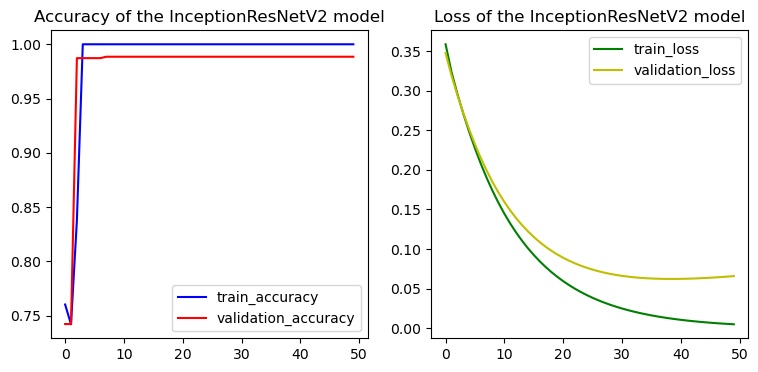

In [24]:
import matplotlib.pyplot as plt

# Create a figure and two subplots, side by side
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

# Plot the accuracy score of our model in the left subplot
ax[0].plot(history_inception_resnet_v2_radimagenet.history['accuracy'], c = 'b', label = 'train_accuracy')
ax[0].plot(history_inception_resnet_v2_radimagenet.history['val_accuracy'], c = 'r', label = 'validation_accuracy')
ax[0].set_title('Accuracy of the InceptionResNetV2 model')
ax[0].legend()

# Plot the loss value of our model in the right subplot
ax[1].plot(history_inception_resnet_v2_radimagenet.history['loss'], c = 'g', label = 'train_loss')
ax[1].plot(history_inception_resnet_v2_radimagenet.history['val_loss'], c = 'y', label = 'validation_loss')
ax[1].set_title('Loss of the InceptionResNetV2 model')
ax[1].legend()

# Show the plot
plt.show()

## On Metrics: Confusion Matrix, Classification Report, AUC-ROC Curve

In [25]:
# Generate predictions for the validation dataset
y_pred = model_v2_.predict(test_generator)
y_pred = y_pred.round()

# Get the true classes
y_true = test_generator.classes

39/39 [==============================] - 14s 264ms/step


## Confusion Matrix

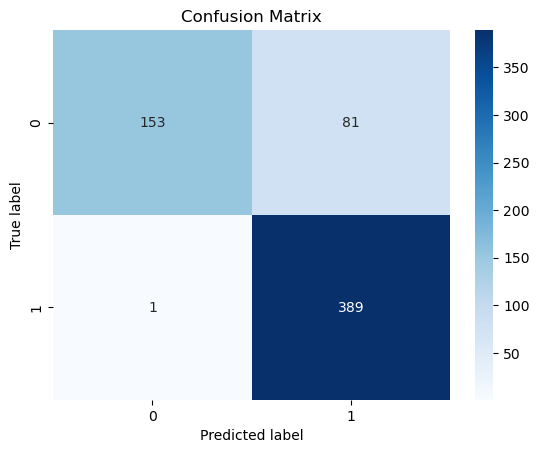

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the heatmap
sns.heatmap(confusion_mtx, annot = True, fmt = 'd', cmap = 'Blues')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Classification Report

In [28]:
from sklearn.metrics import classification_report

# Class names
class_names = list(test_generator.class_indices.keys())

# Get the classification report
class_report = classification_report(y_true, y_pred, target_names = class_names)

# Print the classification report
print(class_report)

              precision    recall  f1-score   support

      NORMAL       0.99      0.65      0.79       234
   PNEUMONIA       0.83      1.00      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.83      0.85       624
weighted avg       0.89      0.87      0.86       624



## AUC-ROC Curve

39/39 [==============================] - 11s 270ms/step


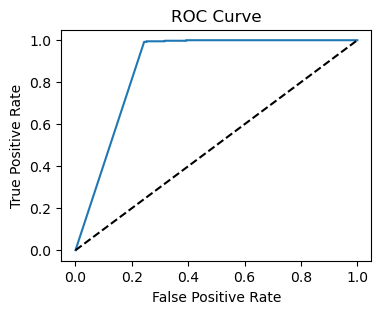

In [29]:
from sklearn.metrics import roc_curve

# Generate predictions for the test dataset
y_test_pred_probs = model_v2_.predict(test_generator)

# Get the corresponding false positive rate and true positive rate for the ROC curve
FPR, TPR, _ = roc_curve(y_true, y_test_pred_probs)

# Set the size of the figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the ROC curve
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black') # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()